In [ ]:
from torchvision import datasets
import torch
data_folder = '/content/' # This can be any directory you want to download FMNIST to
fmnist = datasets.CIFAR10(data_folder, download=True, train=True)

tr_images = fmnist.data
tr_targets = fmnist.targets

val_fmnist = datasets.CIFAR10(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

100%|██████████| 170M/170M [00:05<00:00, 29.4MB/s]


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np

class CIFAR10Dataset(Dataset):
    def __init__(self, images, targets, device='cpu'):
        # Convertir les tableaux NumPy en tenseurs PyTorch
        images = torch.from_numpy(images).float() / 255.0
        targets = torch.tensor(targets, dtype=torch.long)

        # CIFAR10 : images en 3x32x32, format (N, H, W, C) -> (N, C, H, W)
        images = images.permute(0, 3, 1, 2)

        self.x = images
        self.y = targets
        self.device = device

    def __getitem__(self, ix):
        x = self.x[ix].to(self.device)
        y = self.y[ix].to(self.device)
        return x, y

    def __len__(self):
        return len(self.x)


In [ ]:
import torch
import torch.nn as nn

def get_model(device='cpu'):
    model = nn.Sequential(
        # Bloc 1
        nn.Conv2d(3, 16, kernel_size=5, padding=2, bias=True),  # 64 → 16
        nn.ReLU(),
        nn.BatchNorm2d(16),

        nn.Conv2d(16, 16, kernel_size=5, padding=2, bias=True),
        nn.ReLU(),
        nn.Dropout2d(0.1),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(2),  # 32x32 → 16x16

        # Bloc 2
        nn.Conv2d(16, 32, kernel_size=5, padding=2, bias=True),  # 128 → 32
        nn.ReLU(),
        nn.Dropout2d(0.1),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),  # 16x16 → 8x8

        # Bloc 3
        nn.Conv2d(32, 32, kernel_size=5, padding=2, bias=True),
        nn.ReLU(),
        nn.Dropout2d(0.1),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),  # 8x8 → 4x4

        # Classificateur
        nn.Flatten(),              # 32 * 4 * 4 = 512
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(64, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    return model, loss_fn, optimizer


In [ ]:
def get_data():
    train = CIFAR10Dataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = CIFAR10Dataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [ ]:
# Définir le device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Charger les données
trn_dl, val_dl = get_data()

# Initialiser le modèle
model, loss_fn, optimizer = get_model(device=device)

# Afficher un résumé du modèle
from torchsummary import summary
summary(model, (3, 32, 32))  # CIFAR10 : 3 canaux, 32x32


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]           1,216
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           6,416
              ReLU-5           [-1, 16, 32, 32]               0
         Dropout2d-6           [-1, 16, 32, 32]               0
       BatchNorm2d-7           [-1, 16, 32, 32]              32
         MaxPool2d-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]          12,832
             ReLU-10           [-1, 32, 16, 16]               0
        Dropout2d-11           [-1, 32, 16, 16]               0
      BatchNorm2d-12           [-1, 32, 16, 16]              64
        MaxPool2d-13             [-1, 32, 8, 8]               0
           Conv2d-14             [-1, 3

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(6):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        x, y = x.to(device), y.to(device)
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        x, y = x.to(device), y.to(device)
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        x, y = x.to(device), y.to(device)
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)


0
1
2
3
4
5


**INTERPOLATION DU FILTRE**

In [ ]:
def interpolate_filter(filter_weights, smooth_factor=50):
    """Interpolation cubique bilinéaire pour passer du filtre discret à une fonction continue"""
    h, w = filter_weights.shape
    y = np.arange(h)
    x = np.arange(w)
    interp_func = RegularGridInterpolator((y, x), filter_weights, method='cubic')
    ynew = np.linspace(0, h-1, smooth_factor)
    xnew = np.linspace(0, w-1, smooth_factor)
    X, Y = np.meshgrid(xnew, ynew)
    points = np.array([Y.ravel(), X.ravel()]).T
    Zsmooth = interp_func(points).reshape(smooth_factor, smooth_factor)
    return Zsmooth

**Projection dans schwartz**

In [ ]:
def project_to_schwartz(Zsmooth, sigma=None):
    """Projette un filtre interpolé dans un espace proche de S(R^2) via une fenêtre gaussienne"""
    H, W = Zsmooth.shape
    if sigma is None:
        sigma = min(H, W) / 2
    y = np.arange(H) - H/2
    x = np.arange(W) - W/2
    X, Y = np.meshgrid(x, y)
    gauss_window = np.exp(-(X**2 + Y**2) / (2*sigma**2))
    Z_schwartz = Zsmooth * gauss_window
    return Z_schwartz

**Mesure de régularité**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def gaussian_window(shape, sigma=1.0, center=None):
    """Fenêtre gaussienne normalisée 2D"""
    n, m = shape
    if center is None:
        center = (n//2, m//2)
    y = np.arange(n) - center[0]
    x = np.arange(m) - center[1]
    X, Y = np.meshgrid(x, y)
    g = np.exp(-(X**2 + Y**2)/(2*sigma**2))
    g /= np.sqrt(np.sum(g**2))
    return g

def local_sobolev_gauss_3D(h, block_size=(5,5), alpha=2, sigma=1.0):
    """
    Calcule la régularité locale de sous-blocs d'un filtre 2D
    avec fenêtre gaussienne et pondération Sobolev.

    Retour :
    - reg_map : matrice de régularité locale
    """
    n, m = h.shape
    bh, bw = block_size
    reg_map = np.zeros((n - bh + 1, m - bw + 1))

    for i in range(n - bh + 1):
        for j in range(m - bw + 1):
            block = h[i:i+bh, j:j+bw]
            g = gaussian_window(block.shape, sigma=sigma)
            block_win = block * g

            H = np.fft.fft2(block_win)
            H = np.fft.fftshift(H)

            u = np.fft.fftshift(np.fft.fftfreq(bh))
            v = np.fft.fftshift(np.fft.fftfreq(bw))
            U, V = np.meshgrid(u, v, indexing='ij')

            freq_weight = (1 + U**2 + V**2)**alpha
            reg_map[i,j] = np.sum(freq_weight * np.abs(H)**2)

    return reg_map


**Récupération des poids réguliers**

In [ ]:
def graphcut_filter_surface(Zsmooth, percentile=20):
    """
    Conserve uniquement les valeurs les plus petites (en valeur absolue)
    selon un seuil basé sur le percentile.
    #
    Zsmooth : surface lissée (2D numpy array)
    percentile : pourcentage de valeurs à conserver (les plus petites)
    """
    threshold = np.percentile(np.abs(Zsmooth), percentile)
    mask = np.abs(Zsmooth) <= threshold  # True là où on garde
    Zcut = np.where(mask, Zsmooth, np.nan)  # NaN pour visualiser les trous
    return Zcut, mask

# Application sur reg_map
#Zcut, mask = graphcut_filter_surface(reg_map, percentile=50)

Mesure de valeur

In [ ]:
def magnitude_mesure(Zcut):
    """
    Calcule la somme des valeurs absolues de Zcut.
    Les NaN sont traités comme des zéros.
    """
    return np.nansum(np.abs(Zcut))

In [ ]:
def ultimate_graphcut_filter_analysis_reg(filter_weights):
  Zsmooth = interpolate_filter(filter_weights)
  Z_schwartz = project_to_schwartz(Zsmooth)
  reg_map = local_sobolev_gauss_3D(Zsmooth, block_size=(5,5), alpha=2, sigma=1.0)
  Zcut, mask = graphcut_filter_surface(reg_map, percentile=20)
  return magnitude_mesure(Zcut)

**Classement des filtres**

In [ ]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]           1,216
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]           6,416
              ReLU-5           [-1, 16, 32, 32]               0
         Dropout2d-6           [-1, 16, 32, 32]               0
       BatchNorm2d-7           [-1, 16, 32, 32]              32
         MaxPool2d-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]          12,832
             ReLU-10           [-1, 32, 16, 16]               0
        Dropout2d-11           [-1, 32, 16, 16]               0
      BatchNorm2d-12           [-1, 32, 16, 16]              64
        MaxPool2d-13             [-1, 32, 8, 8]               0
           Conv2d-14             [-1, 3

In [ ]:
from scipy.interpolate import RegularGridInterpolator
conv_layers = [module for module in model.modules() if isinstance(module, nn.Conv2d)]

filter_ranking = {}
conv_layers = [m for m in model.modules() if isinstance(m, torch.nn.Conv2d)]

for m_idx, conv_layer in enumerate(conv_layers):
    print(f"   Couche {m_idx+1}/{len(conv_layers)}...")
    filter_ranking[m_idx] = {}

    out_channels, in_channels, h, w = conv_layer.weight.shape

    for oc in range(out_channels):
        print(oc)
        filter_ranking[m_idx][oc] = {}
        for ic in range(in_channels):
            print(ic)
                # 1. Importance GraphCut multi-échelle + structurelle
            filter_weights = conv_layer.weight[oc, ic].detach().cpu().numpy()
            base_importance = ultimate_graphcut_filter_analysis_reg(filter_weights)

                # 2. Correction contextuelle (redondance)
            #redundancy_factor = contextual_redundancy_check(conv_layer, oc, ic)

                # 3. Score final
            #final_importance = base_importance * redundancy_factor
            filter_ranking[m_idx][oc][ic] = float(base_importance)

   Couche 1/4...
0
0
1
2
1
0
1
2
2
0
1
2
3
0
1
2
4
0
1
2
5
0
1
2
6
0
1
2
7
0
1
2
8
0
1
2
9
0
1
2
10
0
1
2
11
0
1
2
12
0
1
2
13
0
1
2
14
0
1
2
15
0
1
2
   Couche 2/4...
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
5
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
6
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
7
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
8
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
11
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
13
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
14
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
   Couche 3/4...
0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
4
0
1
2
3

In [ ]:
filter_ranking

{0: {0: {0: 6.965900770224636, 1: 2.980007526118758, 2: 3.03821874193555},
  1: {0: 4.564288365269535, 1: 5.999807607866493, 2: 4.873704623472269},
  2: {0: 5.111575870499241, 1: 3.468271886690179, 2: 1.5772259409310694},
  3: {0: 5.3195794474925835, 1: 2.233252689302897, 2: 5.197712128145371},
  4: {0: 2.4791868347104904, 1: 4.808416007300519, 2: 1.2213777175659053},
  5: {0: 3.1571076287245523, 1: 2.3674376700021416, 2: 5.4100857663632},
  6: {0: 6.457230244233056, 1: 2.0384423483721026, 2: 6.228639587683963},
  7: {0: 8.918024367508949, 1: 6.674194859354812, 2: 6.061433544959715},
  8: {0: 3.9077113052123513, 1: 6.052075598360608, 2: 4.496383209929037},
  9: {0: 5.907845380502608, 1: 2.472079646150395, 2: 5.108989197569615},
  10: {0: 3.944795547887996, 1: 1.198616052739446, 2: 32.44656641904763},
  11: {0: 7.4656743092379205, 1: 11.145567906002922, 2: 13.365457400086875},
  12: {0: 6.840396798958277, 1: 3.7735719777756707, 2: 5.332115589008468},
  13: {0: 8.782523924568771, 1: 2.92

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_filter_ranking_combined(filter_ranking):
    """
    Affiche tous les filtres de toutes les couches dans un seul graphe,
    avec une ligne rouge séparant les couches.

    Args:
        filter_ranking : dict[layer_idx][out_ch][in_ch] = score
    """
    all_scores = []
    layer_boundaries = []
    current_idx = 0

    # Parcourir les couches
    for l_idx in sorted(filter_ranking.keys()):
        layer_dict = filter_ranking[l_idx]
        # Moyenne sur les canaux d'entrée pour chaque filtre de sortie
        out_scores = [np.mean(list(layer_dict[oc].values())) for oc in sorted(layer_dict.keys())]
        all_scores.extend(out_scores)
        current_idx += len(out_scores)
        layer_boundaries.append(current_idx)  # position pour la ligne rouge

    # Plot
    plt.figure(figsize=(12,5))
    plt.bar(range(len(all_scores)), all_scores)
    plt.xlabel("Filtres (toutes couches concaténées)")
    plt.ylabel("Score d'importance moyen")
    plt.title("Importance des filtres par couche")

    # Tracer les lignes rouges pour séparer les couches
    for b in layer_boundaries[:-1]:  # pas besoin de la dernière
        plt.axvline(x=b-0.5, color='red', linestyle='--', linewidth=1)

    plt.show()


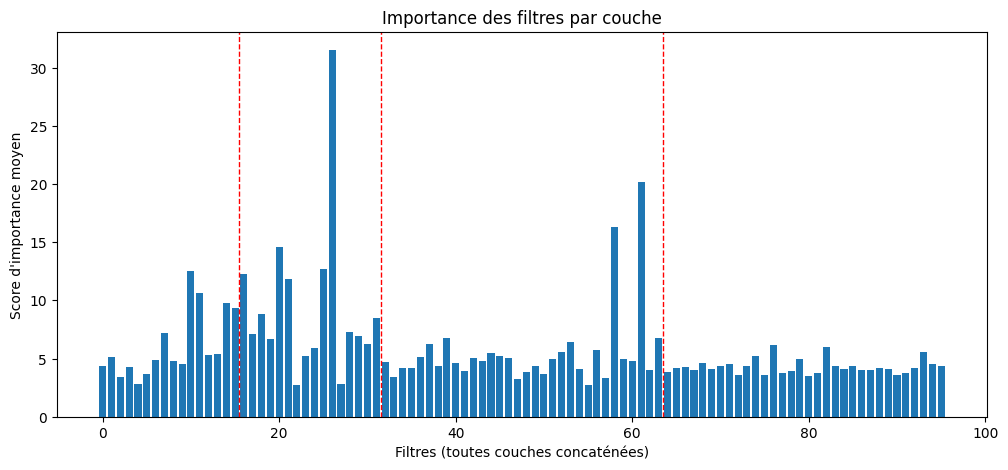

In [ ]:
plot_filter_ranking_combined(filter_ranking)


In [ ]:
import json
with open("reg_pure_20.json", "w") as f:
    json.dump(filter_ranking, f, indent=4)
from google.colab import files
files.download("reg_pure_20.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Sélection des filtres**

In [ ]:
def keep_top_percentile_filters(filter_ranking, percentile):
    """
    Keeps the top 'percentile' of filters based on their base_importance score.

    Args:
        filter_ranking (dict): A dictionary containing the ranking of filters.
                               Expected format: {layer_idx: {out_channel_idx: {in_channel_idx: base_importance}}}
        percentile (int): The percentile to keep (e.g., 10 for top 10%).

    Returns:
        dict: A new dictionary containing only the top percentile filters.
    """
    all_importances = []
    # Collect all base_importance values
    for layer_idx, out_channels in filter_ranking.items():
        for out_channel_idx, in_channels in out_channels.items():
            for in_channel_idx, importance in in_channels.items():
                # Only consider non-NaN importance values
                if not np.isnan(importance):
                    all_importances.append(importance)

    if not all_importances:
        print("No valid importance values found.")
        return {}

    # Calculate the threshold based on the percentile
    threshold = np.percentile(all_importances, 100 - percentile) # Keep values >= threshold

    # Create a new dictionary with only the top percentile filters
    top_filters_ranking = {}
    for layer_idx, out_channels in filter_ranking.items():
        top_filters_ranking[layer_idx] = {}
        for out_channel_idx, in_channels in out_channels.items():
            top_filters_ranking[layer_idx][out_channel_idx] = {}
            for in_channel_idx, importance in in_channels.items():
                if not np.isnan(importance) and importance <= threshold:
                    top_filters_ranking[layer_idx][out_channel_idx][in_channel_idx] = importance

    return top_filters_ranking

**Pruning du modèle*

In [ ]:
import copy
model_test = copy.deepcopy(model)

In [ ]:
import torch
import torch.nn as nn
import copy
from collections import defaultdict
import numpy as np

def prune_model_by_filters_removal(model, top_indices_list, input_size=(3, 32, 32)):
    """
    VERSION CORRIGÉE: Supprime réellement les filtres pour réduire les paramètres.

    Args:
        model: modèle PyTorch nn.Sequential
        top_indices_list: [(layer_idx, out_ch, in_ch), ...] - filtres à CONSERVER
        input_size: taille d'entrée (channels, height, width)

    Returns:
        Modèle pruné avec moins de paramètres
    """
    device = next(model.parameters()).device
    model_copy = copy.deepcopy(model)

    # Organiser les filtres à conserver par couche
    filters_to_keep = defaultdict(set)
    for layer_idx, out_ch, in_ch in top_indices_list:
        filters_to_keep[layer_idx].add(out_ch)

    # Convertir en listes triées
    for layer_idx in filters_to_keep:
        filters_to_keep[layer_idx] = sorted(list(filters_to_keep[layer_idx]))

    new_layers = []
    conv_layers = [i for i, layer in enumerate(model_copy) if isinstance(layer, nn.Conv2d)]
    prev_kept_channels = None

    for i, layer in enumerate(model_copy):
        if isinstance(layer, nn.Conv2d):
            # Trouver l'index de cette couche conv
            conv_idx = conv_layers.index(i)

            # Déterminer les canaux de sortie à conserver
            if conv_idx in filters_to_keep:
                keep_out_channels = filters_to_keep[conv_idx]
            else:
                # Si pas spécifié, garder tous les canaux
                keep_out_channels = list(range(layer.out_channels))

            # Déterminer les canaux d'entrée
            if conv_idx == 0:
                # Première couche: garder tous les canaux d'entrée (RGB)
                new_in_channels = layer.in_channels
                keep_in_channels = list(range(layer.in_channels))
            else:
                # Couches suivantes: s'adapter aux canaux conservés de la couche précédente
                new_in_channels = len(prev_kept_channels) if prev_kept_channels else layer.in_channels
                keep_in_channels = prev_kept_channels if prev_kept_channels else list(range(layer.in_channels))

            new_out_channels = len(keep_out_channels)

            # Créer la nouvelle couche Conv2d RÉDUITE
            new_conv = nn.Conv2d(
                in_channels=new_in_channels,
                out_channels=new_out_channels,
                kernel_size=layer.kernel_size,
                stride=layer.stride,
                padding=layer.padding,
                bias=(layer.bias is not None)
            ).to(device)

            # Copier uniquement les poids des filtres conservés
            with torch.no_grad():
                for new_out_idx, old_out_idx in enumerate(keep_out_channels):
                    for new_in_idx, old_in_idx in enumerate(keep_in_channels):
                        new_conv.weight[new_out_idx, new_in_idx] = layer.weight[old_out_idx, old_in_idx]

                    if layer.bias is not None:
                        new_conv.bias[new_out_idx] = layer.bias[old_out_idx]

            new_layers.append(new_conv)
            prev_kept_channels = keep_out_channels

        elif isinstance(layer, nn.BatchNorm2d):
            # Adapter BatchNorm aux canaux conservés
            if prev_kept_channels is not None:
                new_bn = nn.BatchNorm2d(len(prev_kept_channels)).to(device)
                with torch.no_grad():
                    for new_idx, old_idx in enumerate(prev_kept_channels):
                        new_bn.weight[new_idx] = layer.weight[old_idx]
                        new_bn.bias[new_idx] = layer.bias[old_idx]
                        new_bn.running_mean[new_idx] = layer.running_mean[old_idx]
                        new_bn.running_var[new_idx] = layer.running_var[old_idx]
                new_layers.append(new_bn)
            else:
                new_layers.append(copy.deepcopy(layer))

        elif isinstance(layer, nn.Linear):
            # Ajuster la première couche Linear après Flatten
            if len([l for l in new_layers if isinstance(l, nn.Linear)]) == 0:
                # Calculer la nouvelle taille après les couches conv
                new_input_features = calculate_linear_input_size(new_layers, input_size)

                new_linear = nn.Linear(
                    in_features=new_input_features,
                    out_features=layer.out_features,
                    bias=(layer.bias is not None)
                ).to(device)

                # Copier les poids (avec adaptation de taille)
                with torch.no_grad():
                    min_features = min(new_input_features, layer.in_features)
                    new_linear.weight[:, :min_features] = layer.weight[:, :min_features]
                    if layer.bias is not None:
                        new_linear.bias[:] = layer.bias[:]

                new_layers.append(new_linear)
            else:
                # Autres couches Linear: copier tel quel
                new_layers.append(copy.deepcopy(layer))
        else:
            # Autres couches (ReLU, MaxPool, Dropout, Flatten)
            new_layers.append(copy.deepcopy(layer))

    return nn.Sequential(*new_layers).to(device)

def calculate_linear_input_size(conv_layers, input_size):
    """
    Calcule la taille d'entrée pour la première couche Linear
    en simulant une passe avant à travers les couches conv.
    """
    channels, h, w = input_size

    for layer in conv_layers:
        if isinstance(layer, nn.Conv2d):
            # Calculer nouvelle taille après convolution
            kernel_size = layer.kernel_size[0] if isinstance(layer.kernel_size, tuple) else layer.kernel_size
            stride = layer.stride[0] if isinstance(layer.stride, tuple) else layer.stride
            padding = layer.padding[0] if isinstance(layer.padding, tuple) else layer.padding

            h = (h + 2*padding - kernel_size) // stride + 1
            w = (w + 2*padding - kernel_size) // stride + 1
            channels = layer.out_channels

        elif isinstance(layer, nn.MaxPool2d):
            kernel_size = layer.kernel_size
            stride = layer.stride if layer.stride else kernel_size
            h = h // stride
            w = w // stride

    return channels * h * w

def structured_channel_pruning(model, importance_dict, keep_ratio=0.5):
    """
    Pruning structuré: supprime des canaux entiers basé sur leur importance moyenne.
    Plus efficace pour réduire réellement les paramètres.

    Args:
        model: modèle à pruner
        importance_dict: dict[layer][out_ch][in_ch] = importance
        keep_ratio: fraction de canaux à conserver (0.5 = 50%)
    """
    # Calculer l'importance moyenne par canal de sortie
    channel_importance = {}

    for layer_idx in importance_dict:
        channel_importance[layer_idx] = {}
        for out_ch in importance_dict[layer_idx]:
            # Moyenne d'importance sur tous les canaux d'entrée pour ce canal de sortie
            avg_importance = np.mean(list(importance_dict[layer_idx][out_ch].values()))
            channel_importance[layer_idx][out_ch] = avg_importance

    # Sélectionner les top canaux pour chaque couche
    top_indices = []
    for layer_idx in channel_importance:
        # Trier par importance décroissante
        channels_by_importance = sorted(
            channel_importance[layer_idx].items(),
            key=lambda x: x[1],
            reverse=False
        )

        # Garder le top keep_ratio
        n_keep = max(1, int(len(channels_by_importance) * keep_ratio))
        top_channels = [ch for ch, _ in channels_by_importance[:n_keep]]

        # Créer les indices pour tous les canaux d'entrée de ces canaux de sortie
        for out_ch in top_channels:
            for in_ch in importance_dict[layer_idx][out_ch]:
                top_indices.append((layer_idx, out_ch, in_ch))

    return top_indices

def test_effective_pruning(model, importance_dict, trn_dl, val_dl, loss_fn, keep_ratios=[0.8, 0.6, 0.4, 0.2]):
    """
    Test de pruning avec réduction EFFECTIVE des paramètres.
    """
    print("Test de Pruning avec Réduction Effective des Paramètres")
    print("="*60)

    # Baseline
    orig_params = sum(p.numel() for p in model.parameters())
    orig_loss, orig_acc = evaluate_model(model, val_dl, loss_fn)

    print(f"Modèle original: {orig_acc:.4f} accuracy, {orig_params:,} paramètres")
    print()

    results = []

    for keep_ratio in keep_ratios:
        print(f"Test avec keep_ratio = {keep_ratio} ({keep_ratio*100:.0f}% des canaux)")
        print("-" * 40)

        try:
            # Pruning structuré par canaux
            top_indices = structured_channel_pruning(model, importance_dict, keep_ratio)
            print(f"Filtres sélectionnés: {len(top_indices)}")

            # Appliquer le pruning EFFECTIF
            pruned_model = prune_model_by_filters_removal(model, top_indices, input_size=(3, 32, 32))

            # Vérifier la réduction
            pruned_params = sum(p.numel() for p in pruned_model.parameters())
            actual_reduction = (orig_params - pruned_params) / orig_params * 100

            print(f"Paramètres avant: {orig_params:,}")
            print(f"Paramètres après: {pruned_params:,}")
            print(f"Réduction RÉELLE: {actual_reduction:.1f}%")

            # Test du modèle pruné
            val_loss_before, val_acc_before = evaluate_model(pruned_model, val_dl, loss_fn)
            print(f"Accuracy avant fine-tuning: {val_acc_before:.4f}")

            # Fine-tuning
            print("Fine-tuning...")
            pruned_model = fine_tune_pruned_model(pruned_model, trn_dl, val_dl, loss_fn, epochs=5, lr=1e-3)

            val_loss_final, val_acc_final = evaluate_model(pruned_model, val_dl, loss_fn)

            accuracy_retention = (val_acc_final / orig_acc) * 100
            compression_ratio = orig_params / pruned_params

            print(f"Accuracy finale: {val_acc_final:.4f}")
            print(f"Rétention accuracy: {accuracy_retention:.1f}%")
            print(f"Ratio de compression: {compression_ratio:.1f}x")
            print()

            results.append({
                'keep_ratio': keep_ratio,
                'actual_reduction': actual_reduction,
                'final_accuracy': val_acc_final,
                'accuracy_retention': accuracy_retention,
                'compression_ratio': compression_ratio,
                'pruned_params': pruned_params
            })

        except Exception as e:
            print(f"Erreur avec keep_ratio {keep_ratio}: {e}")
            print()

    # Résumé des résultats
    print("RÉSUMÉ DES RÉSULTATS")
    print("="*40)
    for r in results:
        print(f"Keep {r['keep_ratio']*100:.0f}%: {r['actual_reduction']:.1f}% réduction, "
              f"{r['accuracy_retention']:.1f}% accuracy, {r['compression_ratio']:.1f}x compression")

    return results

# Fonction d'évaluation (si pas déjà définie)
def evaluate_model(model, val_dl, loss_fn):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for x, y in val_dl:
            device = next(model.parameters()).device
            x, y = x.to(device), y.to(device)
            pred = model(x)
            total_loss += loss_fn(pred, y).item() * x.size(0)
            total_correct += (pred.argmax(1) == y).sum().item()
            total_samples += x.size(0)

    return total_loss / total_samples, total_correct / total_samples

def fine_tune_pruned_model(pruned_model, trn_dl, val_dl, loss_fn, epochs=10, lr=1e-4):
    """Fine-tune le modèle pruné pour récupérer l'accuracy."""
    from torch.optim import Adam

    device = next(pruned_model.parameters()).device
    optimizer = Adam(pruned_model.parameters(), lr=lr)

    for epoch in range(epochs):
        pruned_model.train()
        for x, y in trn_dl:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            output = pruned_model(x)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()

        # Validation check
        val_loss, val_acc = evaluate_model(pruned_model, val_dl, loss_fn)
        if epoch == 0 or (epoch + 1) % 2 == 0:
            print(f"  Epoch {epoch+1}: Val Acc = {val_acc:.4f}")

    return pruned_model

# Usage example:
# Remplacer votre appel par:


In [ ]:
import copy
model_test = copy.deepcopy(model)
test_effective_pruning(model_test,filter_ranking,trn_dl, val_dl, loss_fn) #gardant 50 plus régulière

Test de Pruning avec Réduction Effective des Paramètres
Modèle original: 0.7307 accuracy, 120,858 paramètres

Test avec keep_ratio = 0.8 (80% des canaux)
----------------------------------------
Filtres sélectionnés: 1428
Paramètres avant: 120,858
Paramètres après: 88,081
Réduction RÉELLE: 27.1%
Accuracy avant fine-tuning: 0.1038
Fine-tuning...
  Epoch 1: Val Acc = 0.6595
  Epoch 2: Val Acc = 0.6672
  Epoch 4: Val Acc = 0.6983
Accuracy finale: 0.7235
Rétention accuracy: 99.0%
Ratio de compression: 1.4x

Test avec keep_ratio = 0.6 (60% des canaux)
----------------------------------------
Filtres sélectionnés: 1083
Paramètres avant: 120,858
Paramètres après: 64,114
Réduction RÉELLE: 47.0%
Accuracy avant fine-tuning: 0.1258
Fine-tuning...
  Epoch 1: Val Acc = 0.6033
  Epoch 2: Val Acc = 0.6472
  Epoch 4: Val Acc = 0.6754
Accuracy finale: 0.6910
Rétention accuracy: 94.6%
Ratio de compression: 1.9x

Test avec keep_ratio = 0.4 (40% des canaux)
----------------------------------------
Filtres

[{'keep_ratio': 0.8,
  'actual_reduction': 27.120256830329808,
  'final_accuracy': 0.7235,
  'accuracy_retention': 99.0146434925414,
  'compression_ratio': 1.372123386428401,
  'pruned_params': 88081},
 {'keep_ratio': 0.6,
  'actual_reduction': 46.950967250823275,
  'final_accuracy': 0.691,
  'accuracy_retention': 94.56685370192965,
  'compression_ratio': 1.8850485073462895,
  'pruned_params': 64114},
 {'keep_ratio': 0.4,
  'actual_reduction': 66.51607671813203,
  'final_accuracy': 0.5697,
  'accuracy_retention': 77.96633365266182,
  'compression_ratio': 2.98650785806069,
  'pruned_params': 40468},
 {'keep_ratio': 0.2,
  'actual_reduction': 80.82377666352248,
  'final_accuracy': 0.464,
  'accuracy_retention': 63.50075270288764,
  'compression_ratio': 5.214791163272351,
  'pruned_params': 23176}]

In [ ]:
test_effective_pruning(model_test,filter_ranking,trn_dl, val_dl, loss_fn) #gardant 20 plus régulière

Test de Pruning avec Réduction Effective des Paramètres
Modèle original: 0.7409 accuracy, 120,858 paramètres

Test avec keep_ratio = 0.8 (80% des canaux)
----------------------------------------
Filtres sélectionnés: 1428
Paramètres avant: 120,858
Paramètres après: 88,081
Réduction RÉELLE: 27.1%
Accuracy avant fine-tuning: 0.1443
Fine-tuning...
  Epoch 1: Val Acc = 0.6796
  Epoch 2: Val Acc = 0.6841
  Epoch 4: Val Acc = 0.7129
Accuracy finale: 0.7271
Rétention accuracy: 98.1%
Ratio de compression: 1.4x

Test avec keep_ratio = 0.6 (60% des canaux)
----------------------------------------
Filtres sélectionnés: 1083
Paramètres avant: 120,858
Paramètres après: 64,114
Réduction RÉELLE: 47.0%
Accuracy avant fine-tuning: 0.0966
Fine-tuning...
  Epoch 1: Val Acc = 0.6367
  Epoch 2: Val Acc = 0.6618
  Epoch 4: Val Acc = 0.6960
Accuracy finale: 0.6973
Rétention accuracy: 94.1%
Ratio de compression: 1.9x

Test avec keep_ratio = 0.4 (40% des canaux)
----------------------------------------
Filtres

[{'keep_ratio': 0.8,
  'actual_reduction': 27.120256830329808,
  'final_accuracy': 0.7271,
  'accuracy_retention': 98.13740045890134,
  'compression_ratio': 1.372123386428401,
  'pruned_params': 88081},
 {'keep_ratio': 0.6,
  'actual_reduction': 46.950967250823275,
  'final_accuracy': 0.6973,
  'accuracy_retention': 94.11526521797813,
  'compression_ratio': 1.8850485073462895,
  'pruned_params': 64114},
 {'keep_ratio': 0.4,
  'actual_reduction': 66.51607671813203,
  'final_accuracy': 0.6517,
  'accuracy_retention': 87.9605884734782,
  'compression_ratio': 2.98650785806069,
  'pruned_params': 40468},
 {'keep_ratio': 0.2,
  'actual_reduction': 80.82377666352248,
  'final_accuracy': 0.5286,
  'accuracy_retention': 71.34566068295317,
  'compression_ratio': 5.214791163272351,
  'pruned_params': 23176}]